In [8]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
data_dir = 'C:\\Users\\Public\\Documents\\da'

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    os.path.join(data_dir, 'Agricultural-crops'), 
    subset='training', 
    target_size=(128, 128), 
    batch_size=64, 
    class_mode='categorical'
)

val_data = datagen.flow_from_directory(
    os.path.join(data_dir, 'Agricultural-crops'), 
    subset='validation', 
    target_size=(128, 128), 
    batch_size=64, 
    class_mode='categorical'
)


Found 674 images belonging to 30 classes.
Found 155 images belonging to 30 classes.


In [10]:
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

aug_train_data = aug_datagen.flow_from_directory(os.path.join(data_dir, 'Agricultural-crops'), target_size=(128, 128), batch_size=32, class_mode='categorical')


Found 829 images belonging to 30 classes.


In [11]:
combined_train_data = aug_datagen.flow_from_directory(os.path.join(data_dir, 'Agricultural-crops'), target_size=(128, 128), batch_size=32, class_mode='categorical')

Found 829 images belonging to 30 classes.


Found 829 images belonging to 30 classes.


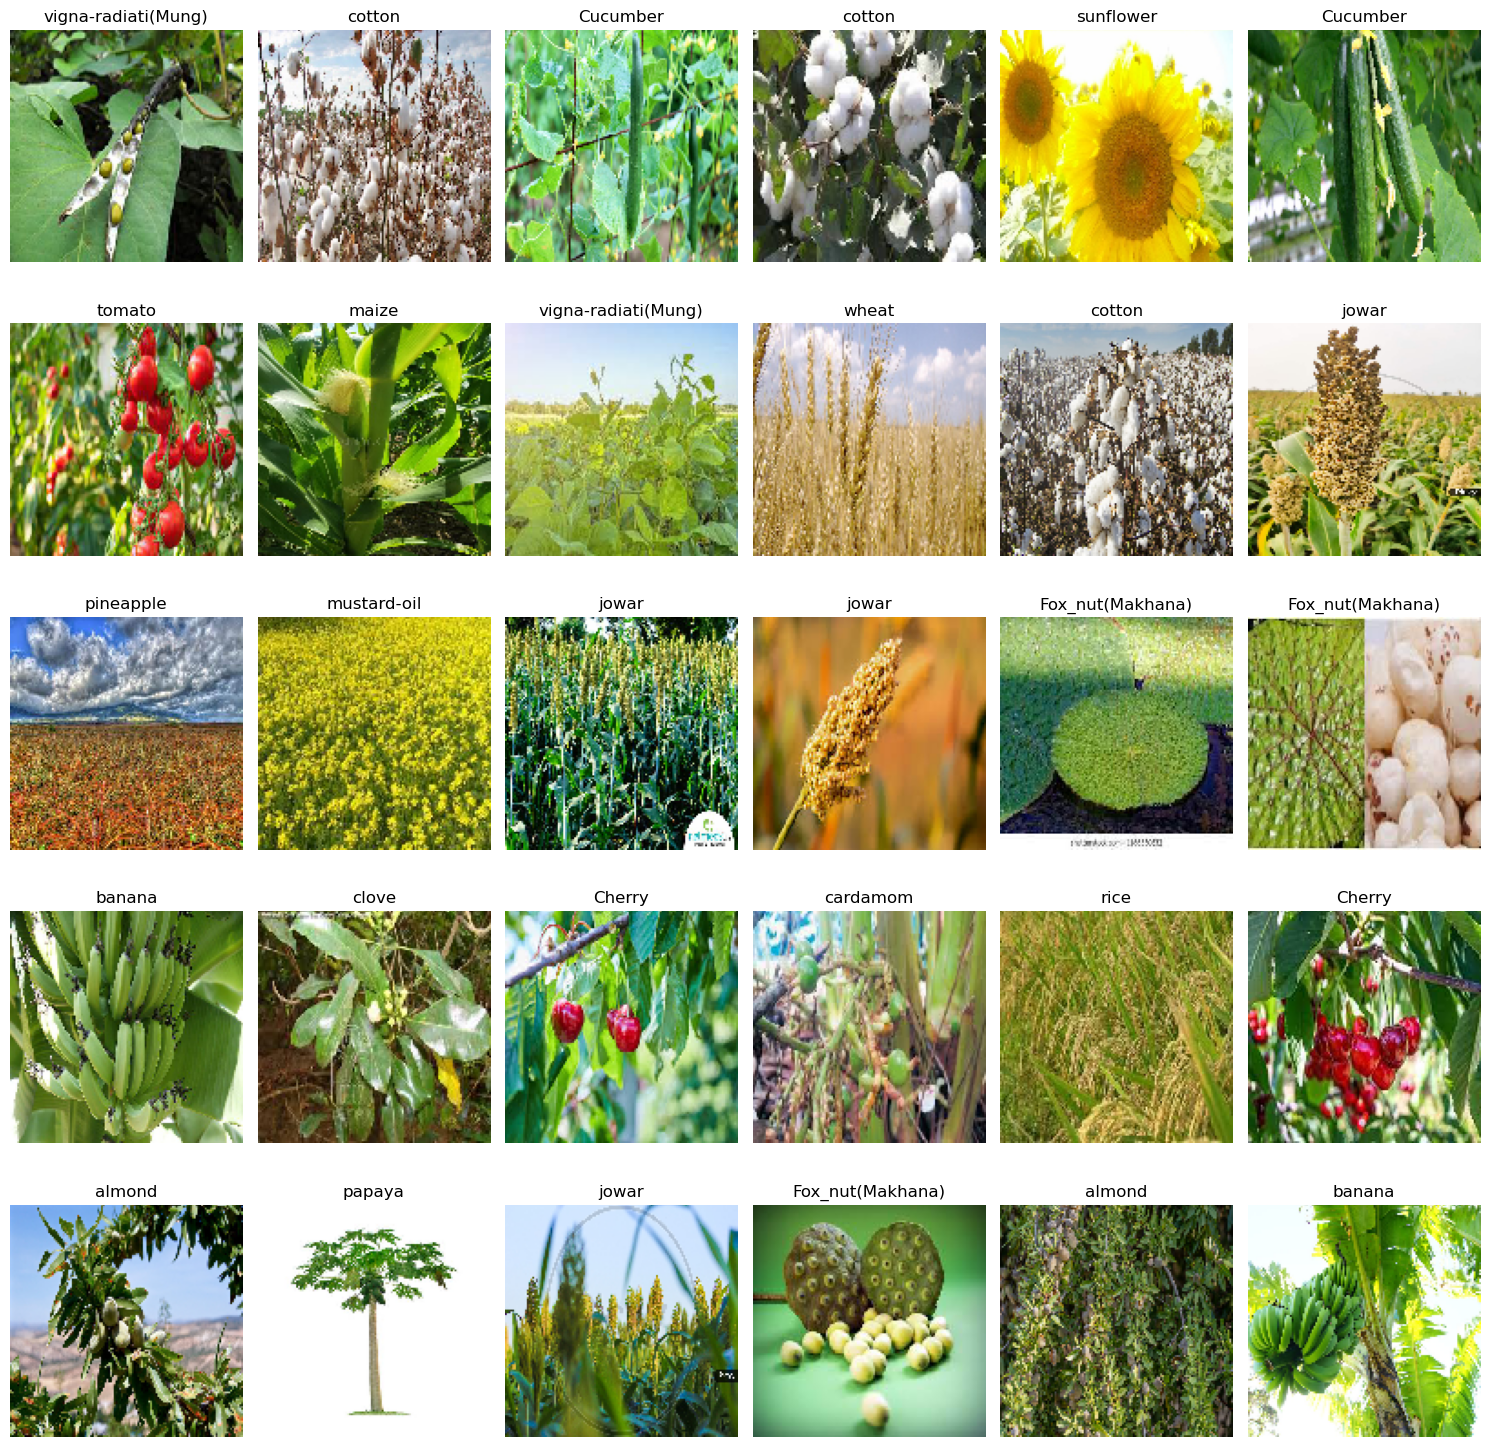

In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = 'C:\\Users\\Public\\Documents\\da'
aug_datagen = ImageDataGenerator()

combined_train_data = aug_datagen.flow_from_directory(
    os.path.join(data_dir, 'Agricultural-crops'), 
    target_size=(128, 128), 
    batch_size=32,  
    class_mode='categorical'  
)

class_dict = {v: k for k, v in combined_train_data.class_indices.items()}


fig, axes = plt.subplots(5, 6, figsize=(15, 15)) 
axes = axes.flatten()
for i, (inputs, labels) in enumerate(combined_train_data):
    ax = axes[i]
    img = inputs[0]
    ax.imshow(img.astype('uint8')) 
    ax.set_title(class_dict[np.argmax(labels[0])])  
    ax.axis('off')
    if i == 29:  
        break

plt.tight_layout()
plt.show()


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

categories = train_data.class_indices

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (128, 128, 3)
num_classes = len(categories)

cnn_model = build_cnn_model(input_shape, num_classes)
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_CNN = cnn_model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping]
)


Epoch 1/50
11/11 [==============================] - 12s 998ms/step - loss: 3.4333 - accuracy: 0.0223 - val_loss: 3.4002 - val_accuracy: 0.0452
Epoch 2/50
11/11 [==============================] - 9s 782ms/step - loss: 3.4004 - accuracy: 0.0386 - val_loss: 3.3992 - val_accuracy: 0.0452
Epoch 3/50
11/11 [==============================] - 10s 928ms/step - loss: 3.3970 - accuracy: 0.0549 - val_loss: 3.3960 - val_accuracy: 0.0452
Epoch 4/50
11/11 [==============================] - 10s 883ms/step - loss: 3.3901 - accuracy: 0.0475 - val_loss: 3.3898 - val_accuracy: 0.0452
Epoch 5/50
11/11 [==============================] - 10s 899ms/step - loss: 3.3595 - accuracy: 0.0415 - val_loss: 3.3710 - val_accuracy: 0.0452
Epoch 6/50
11/11 [==============================] - 10s 917ms/step - loss: 3.3175 - accuracy: 0.0415 - val_loss: 3.3424 - val_accuracy: 0.0645
Epoch 7/50
11/11 [==============================] - 10s 898ms/step - loss: 3.2815 - accuracy: 0.0682 - val_loss: 3.2851 - val_accuracy: 0.0581


In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

categories = train_data.class_indices

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stopping]
)


Epoch 1/50
11/11 [==============================] - 15s 1s/step - loss: 6.3276 - accuracy: 0.2166 - val_loss: 2.2151 - val_accuracy: 0.4323
Epoch 2/50
11/11 [==============================] - 10s 891ms/step - loss: 1.3431 - accuracy: 0.6306 - val_loss: 1.7366 - val_accuracy: 0.5161
Epoch 3/50
11/11 [==============================] - 9s 831ms/step - loss: 0.7544 - accuracy: 0.7849 - val_loss: 1.5937 - val_accuracy: 0.5806
Epoch 4/50
11/11 [==============================] - 10s 887ms/step - loss: 0.4324 - accuracy: 0.8620 - val_loss: 1.4470 - val_accuracy: 0.6194
Epoch 5/50
11/11 [==============================] - 10s 879ms/step - loss: 0.3116 - accuracy: 0.9021 - val_loss: 1.5093 - val_accuracy: 0.6258
Epoch 6/50
11/11 [==============================] - 9s 837ms/step - loss: 0.2684 - accuracy: 0.9214 - val_loss: 1.6884 - val_accuracy: 0.6065
Epoch 7/50
11/11 [==============================] - 10s 873ms/step - loss: 0.2003 - accuracy: 0.9510 - val_loss: 1.8541 - val_accuracy: 0.5871
Epoc

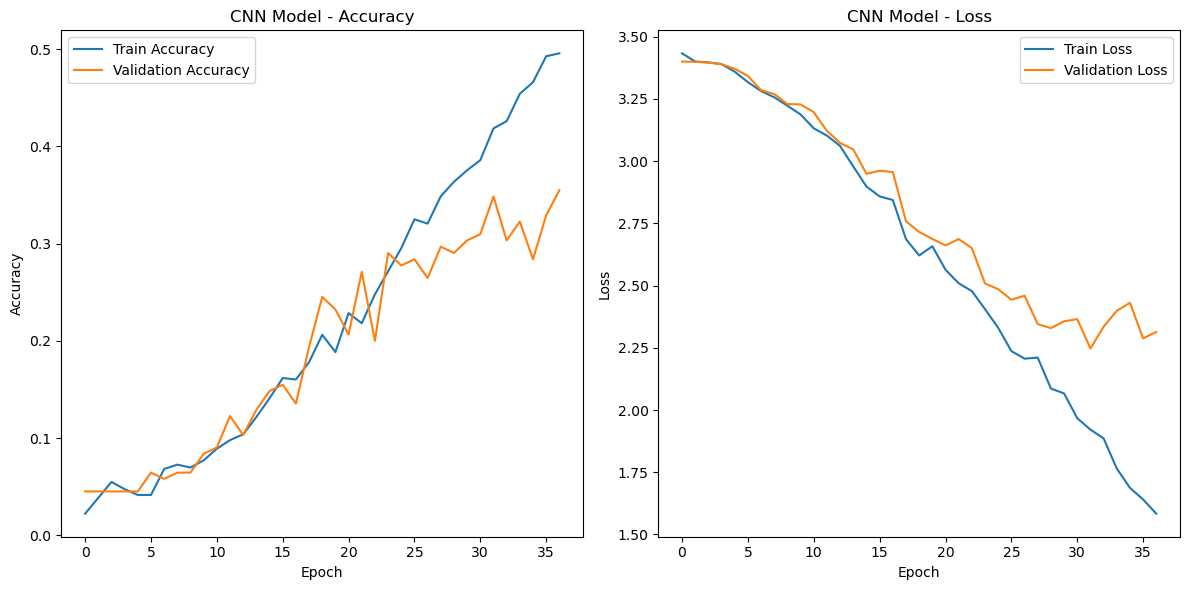

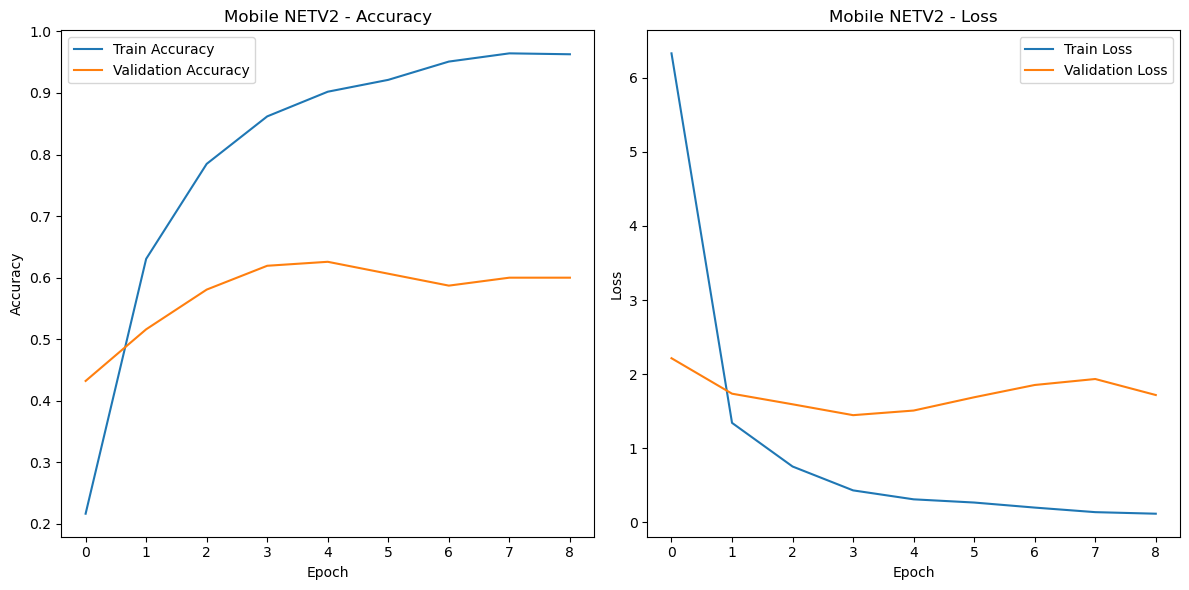

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title(f'{model_name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_CNN, 'CNN Model')
plot_training_history(history, 'Mobile NETV2')


In [ ]:
#Comparing the results from the CNN and MobileNetV2 models, it is clear that MobileNetV2 is significantly more effective for the given task. 
#The CNN model shows high loss on the validation data and low accuracy, which may indicate overfitting or the model's limited ability to generalize.
#This suggests that while the model effectively memorizes the training data, it does not generalize well to new, unseen data.
#In contrast, MobileNetV2 demonstrates significantly lower loss and high accuracy on both training and validation data, indicating its ability to effectively extract features and generalize knowledge.
#These results suggest that MobileNetV2 is better suited to the task, likely due to its more efficient architecture, which is optimized for execution on mobile devices and embedded systems.
#Therefore, these results highlight the importance of choosing the right model based on the task and available resources. 
#MobileNetV2 appears to handle the task better, likely due to its architectural characteristics, making it the preferred choice for this application.